In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='facemo.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('facemo.zip')
f.keys()
!unzip facemo.zip

In [2]:
gpus = tf.config.list_logical_devices('GPU') 
stg=tf.distribute.MirroredStrategy(gpus)

In [3]:
import cv2
import os
from tqdm import tqdm

folder_dir = '/content/facemo/images/train'
SIZE = 75
DOWNSAMPLE_RATIO = 4
JPEG_QUALITY = 100

total_files = sum(len(files) for _, _, files in os.walk(folder_dir))

with tqdm(total=total_files, desc="Processing Images") as pbar:
    for folder in os.listdir(folder_dir):
        for file in os.listdir(os.path.join(folder_dir, folder)):
            if file.endswith("jpg"):
                image_path = os.path.join(folder_dir, folder, file)
                img = cv2.imread(image_path)
                img_resized = cv2.resize(img, (SIZE,SIZE))
                cv2.imwrite(image_path, img_resized)
                pbar.update(1)
            else:
                continue

Processing Images: 100%|██████████| 2827/2827 [00:01<00:00, 2637.97it/s]


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [9]:
batch_size = 32
picture_size = (75, 75)
train_set = tf.keras.utils.image_dataset_from_directory(
    directory=folder_dir,
    shuffle=True,
    image_size=picture_size,
    batch_size=batch_size,
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed = 22
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    directory=folder_dir,
    shuffle=True,
    image_size=picture_size,
    batch_size=batch_size,
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed = 22
)


Found 2827 files belonging to 5 classes.
Using 2262 files for training.
Found 2827 files belonging to 5 classes.
Using 565 files for validation.


In [44]:
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomTranslation, RandomFlip, RandomZoom
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import shutil
import random
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121

no_of_classes = 5

with stg.scope():
    img_augmentation = Sequential(
    [
        RandomRotation(factor=0.2),
        RandomTranslation(height_factor=0.1, width_factor=0.1),
        RandomZoom(height_factor=0.2)
    ],
    name="img_augmentation"
    )

    base_model = DenseNet121(weights="imagenet", input_shape=(SIZE, SIZE, 3), include_top=False)
    inputs = Input(shape=(SIZE, SIZE, 3))
    x = img_augmentation(inputs)
    outputs = base_model(x)

    x = GlobalAveragePooling2D()(outputs)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(no_of_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=predictions)

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.001),
        metrics=['accuracy'])

model.summary()

29084464/29084464 [==============================] - 0s 0us/step


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 75, 75, 3)]       0         
                                                                 
 img_augmentation (Sequentia  (None, 75, 75, 3)        0         
 l)                                                              
                                                                 
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 global_average_pooling2d_8   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_27 (Dense)            (None, 512)               524800    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0   

In [45]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.1,
                                 patience=2,
                                 verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',
                                patience=5,
                                verbose=1)

callbacks = [lr_scheduler, early_stopping]


In [46]:
import tensorflow as tf

model.trainable = True

history = model.fit(train_set, epochs=100, validation_data=validation_set, callbacks=callbacks, 
                    steps_per_epoch=len(train_set), validation_steps=len(validation_set))


Epoch 1/100
71/71 [==============================] - 96s 222ms/step - loss: 1.3417 - accuracy: 0.4545 - val_loss: 10.8883 - val_accuracy: 0.2920 - lr: 0.0010
Epoch 2/100
71/71 [==============================] - 8s 108ms/step - loss: 0.7428 - accuracy: 0.7193 - val_loss: 2.9644 - val_accuracy: 0.4832 - lr: 0.0010
Epoch 3/100
71/71 [==============================] - 9s 122ms/step - loss: 0.5882 - accuracy: 0.7944 - val_loss: 4.2835 - val_accuracy: 0.3858 - lr: 0.0010
Epoch 4/100
71/71 [==============================] - ETA: 0s - loss: 0.3954 - accuracy: 0.8621
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
71/71 [==============================] - 9s 124ms/step - loss: 0.3954 - accuracy: 0.8621 - val_loss: 4.4318 - val_accuracy: 0.4354 - lr: 0.0010
Epoch 5/100
71/71 [==============================] - 8s 109ms/step - loss: 0.2484 - accuracy: 0.9253 - val_loss: 0.3297 - val_accuracy: 0.9062 - lr: 1.0000e-04
Epoch 6/100
71/71 [==============================] - 8

In [47]:
test_loss, test_acc = model.evaluate(validation_set)
print('Test accuracy:', test_acc)

18/18 [==============================] - 1s 20ms/step - loss: 0.0184 - accuracy: 0.9894
Test accuracy: 0.9893805384635925


0 = Angry
1 = Happy
2 = Neutral
3 = Sad
4 = Surprise
1/1 [==============================] - 3s 3s/step


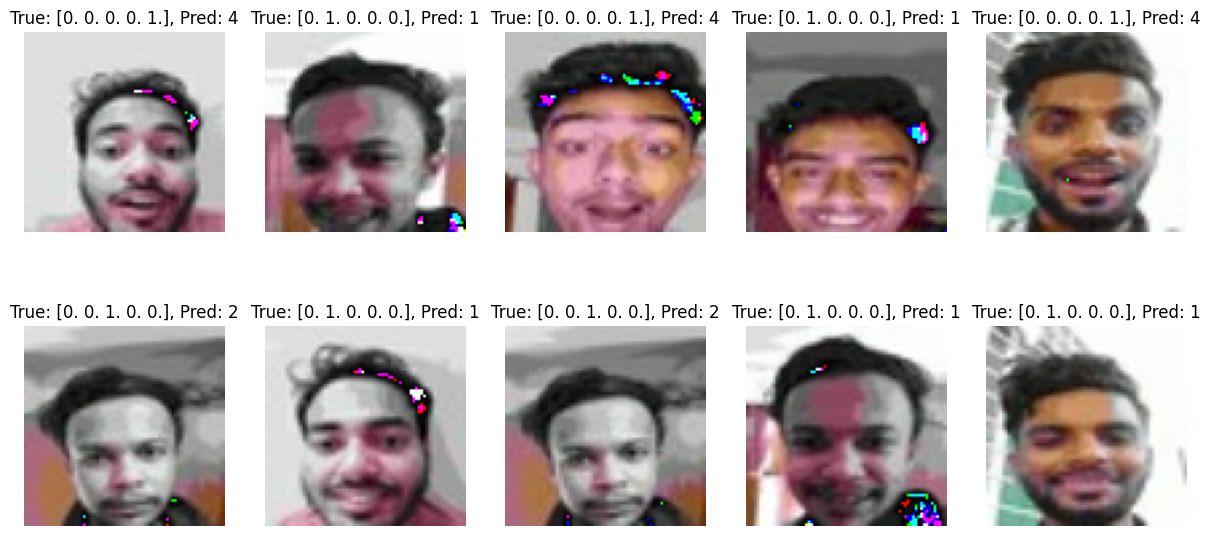

In [48]:
import numpy as np
import matplotlib.pyplot as plt

e = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']
for i in range(len(e)):
    print(i, "=", e[i])

test_batch = next(iter(validation_set))
images = test_batch[0][:10].numpy()
true_labels = test_batch[1][:10]

pred_probs = model.predict(images)
pred_labels = np.argmax(pred_probs, axis=1)

fig, axs = plt.subplots(2, 5, figsize=(15, 7))
axs = axs.flatten()

for i in range(len(images)):
    img = (images[i] * 255).astype(np.uint8)
    img = 255- img
    axs[i].imshow(img)
    axs[i].set_title(f'True: {true_labels[i]}, Pred: {pred_labels[i]}')
    axs[i].axis('off')

plt.show()
